<a href="https://colab.research.google.com/github/OoJackoO/MMAI894_Deep-Learning-Course-Project/blob/dev/MMAI894_Tomato_Disease_CLS_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading & Loading the Dataset

In [1]:
# !pip install -q kaggle
# ! mkdir ~/content/drive/My Drive/Colab Notebooks/MMAI 894
# ! cp kaggle.json ~/content/drive/My Drive/Colab Notebooks/MMAI 894/
# ! chmod 600 ~/kaggle/kaggle.json

In [2]:
# from google.colab import drive
# drive.mount('/gdrive')

In [3]:
# Set the directory to where you want to have your dataset & jason authentication file
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Colab Notebooks/MMAI 894/Dataset"
# %cd /content/drive/My Drive/Colab Notebooks/MMAI 894/Dataset/

In [4]:
# from kaggle.api.kaggle_api_extended import KaggleApi
# import zipfile

In [5]:
# # this will prompt you to upload the kaggle.json
# from google.colab import files

# files.upload() 

In [6]:
# # Check if your jason file is there and authentication is successful
# api = KaggleApi()
# api.authenticate()
# !ls -lha kaggle.json

In [7]:
# # ! kaggle competitions download google-smartphone-decimeter-challenge
# !kaggle datasets download -d cookiefinder/tomato-disease-multiple-sources
# with zipfile.ZipFile('tomato-disease-multiple-sources.zip', 'r') as zip_ref:
#         zip_ref.extractall('./')

# Tomato Leaf Disease

In [27]:
import os
import numpy as np
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
import glob
import cv2

from skimage.io import imread
from skimage.transform import resize
import random

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

import zipfile
from google.colab import drive
from PIL import ImageFile

In [9]:
# Mount Google Drive
drive.mount('/content/drive')

# Set the directory to your specific folder in Google Drive
folder_path = "/content/drive/My Drive/Colab Notebooks/MMAI 894/Dataset/"

# Check if the directory exists and print the list of files and folders inside it
if os.path.exists(folder_path):
    files = os.listdir(folder_path)
    print(files)
else:
    print("Directory does not exist.")

root_dir = "/content/drive/My Drive/" 
# choose where you want your project files to be saved
project_folder = "Colab Notebooks/MMAI 894/Dataset/"
os.chdir(root_dir + project_folder)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['kaggle.json', 'tomato-disease-multiple-sources.zip', 'new_file_in_working_directory.txt', 'train', 'valid']


In [10]:
!pwd

/content/drive/My Drive/Colab Notebooks/MMAI 894/Dataset


In [17]:
main_dir = os.getcwd()
train_dir = os.path.join(main_dir, 'train')
val_dir = os.path.join(main_dir, 'valid')

In [35]:
def define_paths(dir):
    filepaths = []
    labels = []
    disease_names = os.listdir(dir)
    # iterate through each folder od disease
    for disease in disease_names:
        disease_path = os.path.join(dir, disease)
        filelist = os.listdir(disease_path) # list of all images in each disease folder
        #iterate through the folders and save the path and label from folder name
        for file in filelist:
            fpath = os.path.join(disease_path, file)
            filepaths.append(fpath)
            labels.append(disease)
    return filepaths, labels

In [36]:
os.path.join(train_dir, 'Bacterial_spot')

'/content/drive/MyDrive/Colab Notebooks/MMAI 894/Dataset/train/Bacterial_spot'

In [37]:
len(os.listdir(os.path.join(train_dir, 'Bacterial_spot')))

2826

In [39]:
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

In [43]:
def create_df(train_dir, val_dir):
    # train dataframe
    files, classes = define_paths(train_dir)
    train_df = define_df(files, classes)
    
    # valid and test dataframe
    files, classes = define_paths(train_dir)
    dummy_df = define_df(files, classes)
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 24, stratify= strat)
    return train_df, valid_df, test_df

In [22]:
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    ts_length = len(test_df)
    test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size
    def scalar(img):
        return img
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)
    return train_gen, valid_gen, test_gen

In [44]:
def show_images(gen):
    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)
    plt.figure(figsize= (20, 20))
    length = len(labels)
    sample = min(length, 25)
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

Found 25910 validated image filenames belonging to 11 classes.
Found 12955 validated image filenames belonging to 11 classes.
Found 12955 validated image filenames belonging to 11 classes.


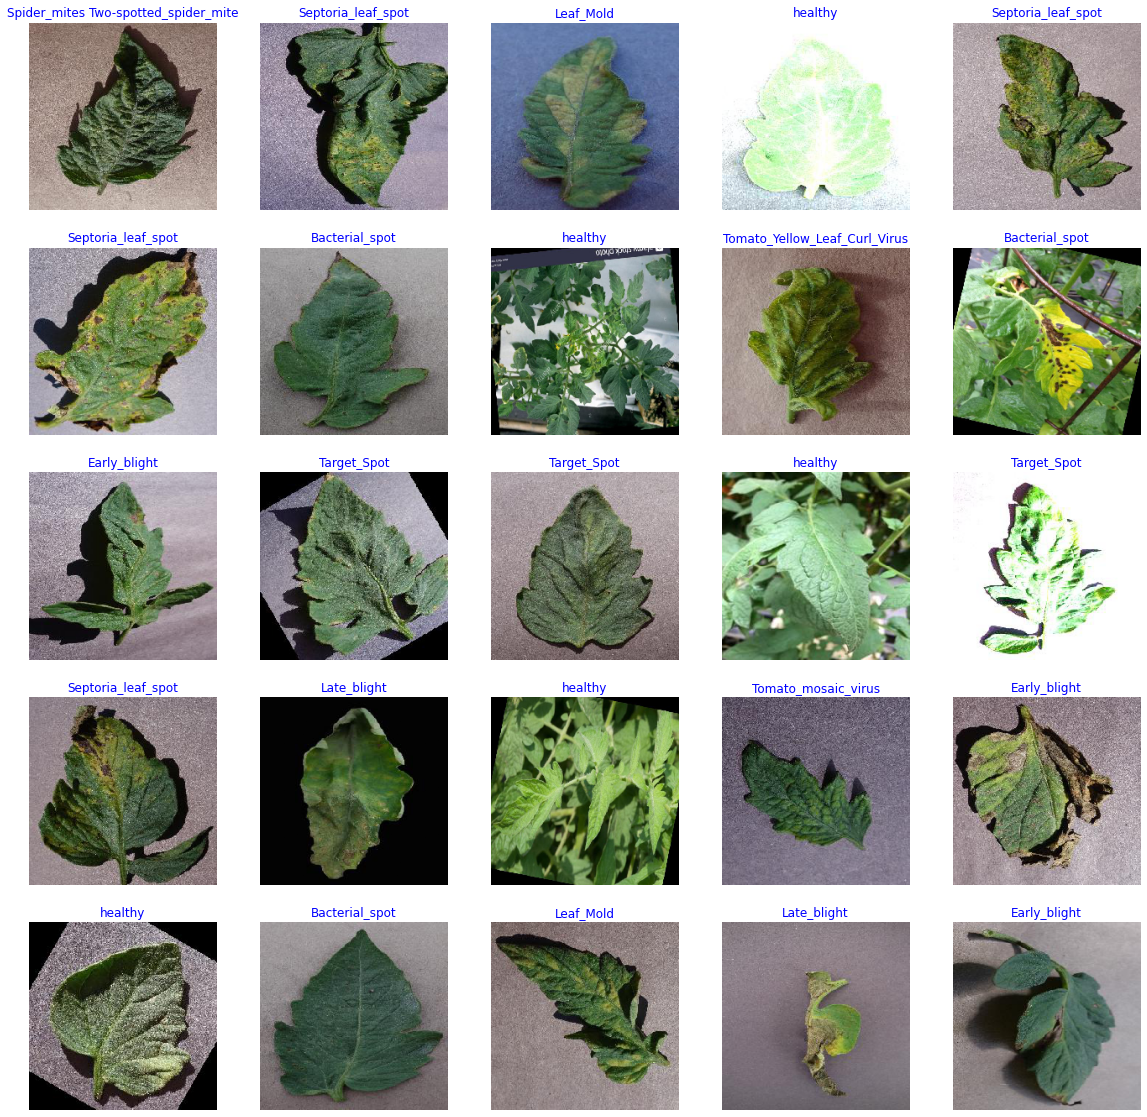

In [45]:
train_df, valid_df, test_df = create_df(train_dir, val_dir)

# Get Generators
batch_size = 40
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

show_images(train_gen)

In [41]:
# Check how many images are in each folder, read through each folder and count the number of images in it
for disease in os.listdir(train_dir):
    disease_dir = os.path.join(train_dir, disease)
    image_list = os.listdir(disease_dir)
    print(disease + ': ' + str(len(image_list)))

Bacterial_spot: 2826
Early_blight: 2514
Late_blight: 3113
Leaf_Mold: 2754
Septoria_leaf_spot: 2882
Spider_mites Two-spotted_spider_mite: 1747
Target_Spot: 1827
Tomato_Yellow_Leaf_Curl_Virus: 2039
Tomato_mosaic_virus: 2153
healthy: 3051
powdery_mildew: 1004


In [42]:
for disease in os.listdir(train_dir):
    disease_dir = os.path.join(val_dir, disease)
    image_list = os.listdir(disease_dir)
    print(disease + ': ' + str(len(image_list)))

Bacterial_spot: 732
Early_blight: 643
Late_blight: 792
Leaf_Mold: 739
Septoria_leaf_spot: 746
Spider_mites Two-spotted_spider_mite: 435
Target_Spot: 457
Tomato_Yellow_Leaf_Curl_Virus: 498
Tomato_mosaic_virus: 584
healthy: 806
powdery_mildew: 252
